In [1]:
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta

In [9]:
def scrape_data(start_date, end_date):
    df = pd.DataFrame()
    dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    for date in dates:
        url = 'https://www.police.uk/gloucestershire/CA1/crime/{}/data/'.format(date.strftime("%Y-%m"))
        mdf = pd.read_json(url)
        mdf['date'] = date
        df = df.append(mdf)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    return df

In [10]:
# Get data from file, or scrape if not present
try:
    df = pd.DataFrame().from_csv('all_crime.csv')
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
except FileNotFoundError:
    start_date = date(2015, 8, 1)
    today = date.today()
    end_date = date(today.year, today.month - 2, 1)
    df = scrape_data(start_date, end_date)
    df.to_csv('all_crime.csv')

/home/seb/.local/share/virtualenvs/stroudcrime/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Add any new data
last_scraped_month = df.sort_values('date').iloc[-1].date.date()
# Stats are published 2 months following collection
two_months_ago = date.today() - relativedelta(months=2)
last_publication_month = date(two_months_ago.year, two_months_ago.month, 1)
if last_publication_month > last_scraped_month:
    new_data = scrape_data(last_scraped_month + relativedelta(months=1), last_publication_month)
df = df.append(new_data)

Text(0.5, 0.98, 'Crimes against the person, smoothed to 12 months')

<Figure size 1440x1280 with 0 Axes>

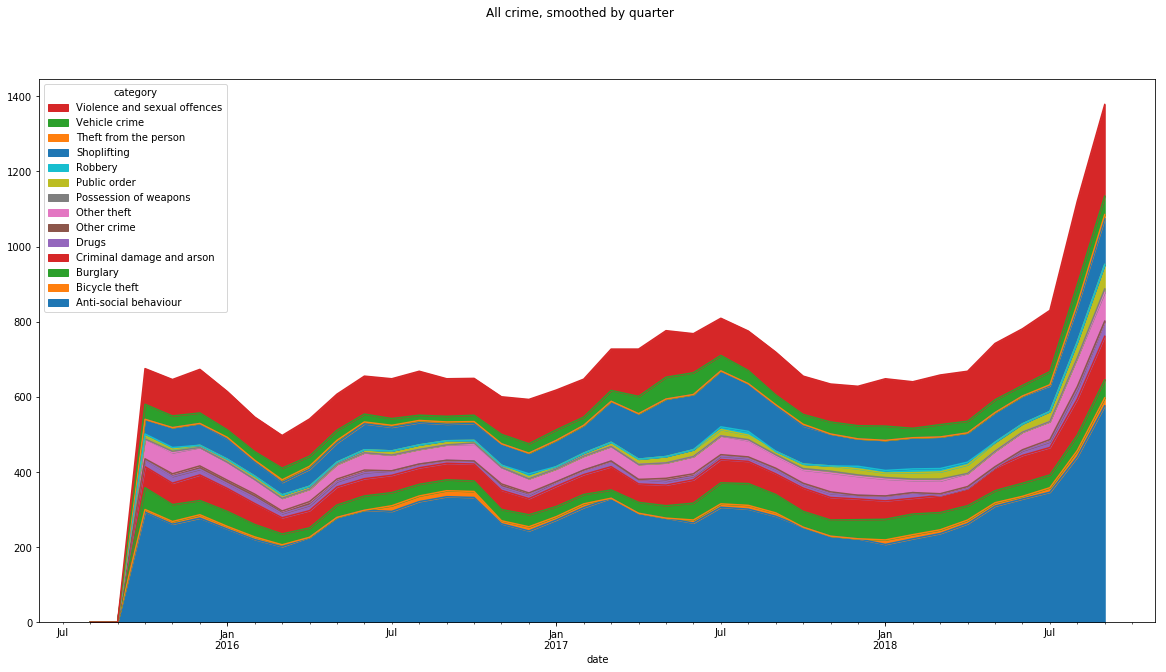

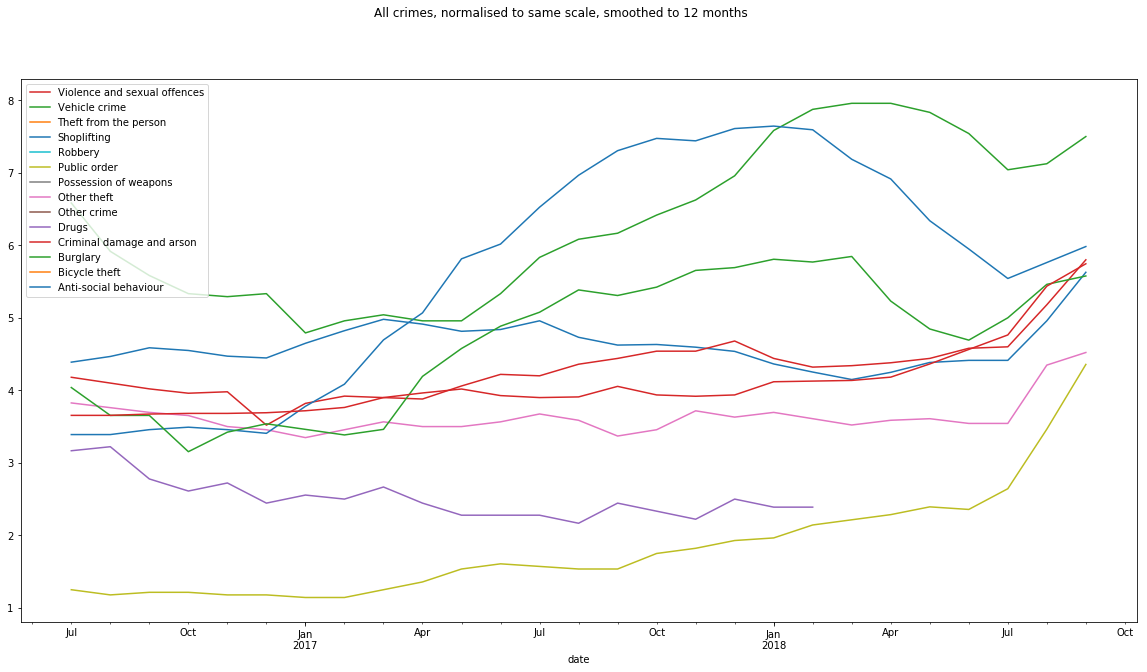

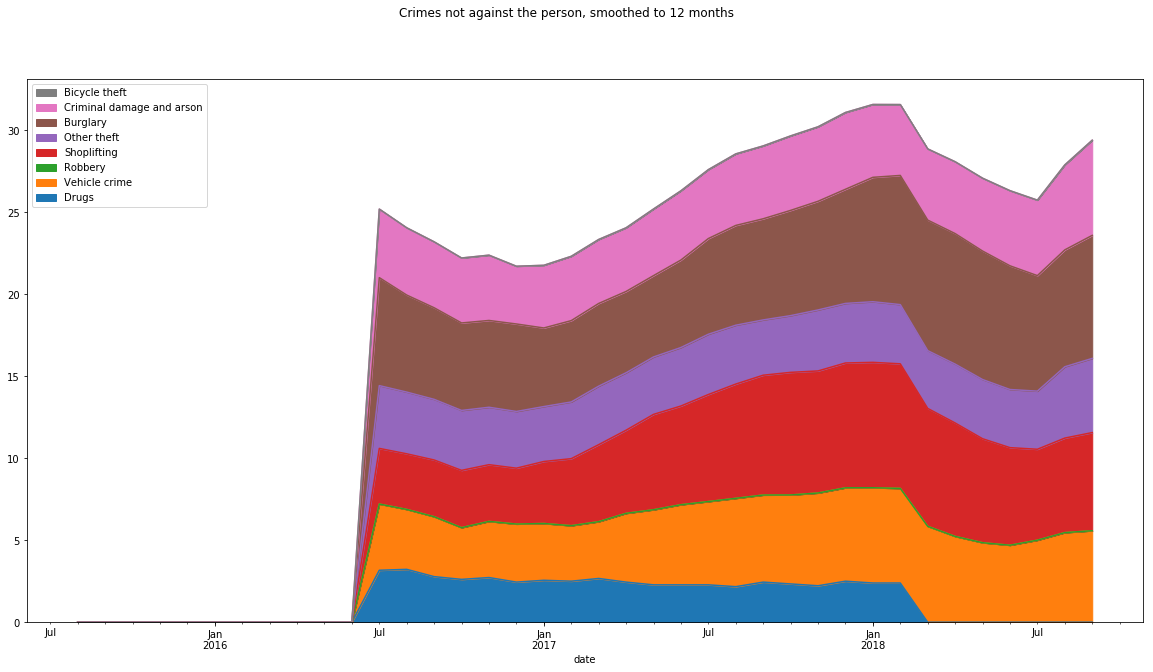

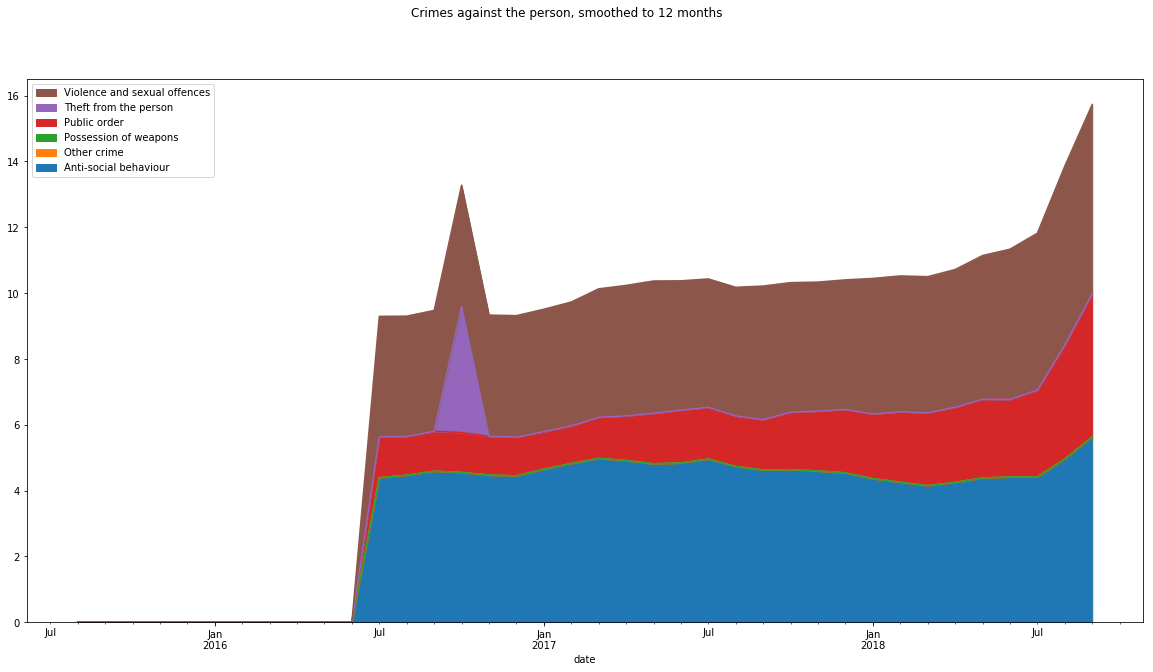

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# Count incidents by month and category
grouped = df.groupby(['category', 'date']).agg('count').reset_index(level=0).pivot_table(
    index='date', columns='category', values='location')

# Restrict to categories with more data
top_categories = ["Anti-social behaviour", "Burglary", "Criminal damage and arson", 
                  "Other theft", "Public order", "Shoplifting", "Vehicle crime", "Violence and sexual offences"]

non_person_crimes = ["Drugs", "Vehicle crime", "Robbery", "Shoplifting", "Other theft", "Burglary", "Criminal damage and arson", "Bicycle theft"]
person_crimes = [x for x in grouped.columns if x not in non_person_crimes]
# Normalise to maximum as baseline
df2 = pd.DataFrame()
for col in grouped.columns:
    df2[col] = grouped[col]/grouped[col].max()

# Plot them
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')

plt.rcParams["figure.figsize"] = (20,10)
grouped.rolling(3).sum().plot.area(legend='reverse')
plt.suptitle("All crime, smoothed by quarter")

ax = df2.rolling(12).sum().plot(legend='reverse')
plt.suptitle("All crimes, normalised to same scale, smoothed to 12 months")


ax = df2[non_person_crimes].rolling(12).sum().plot.area(legend='reverse')
plt.suptitle("Crimes not against the person, smoothed to 12 months")


ax = df2[person_crimes].rolling(12).sum().plot.area(legend='reverse')
plt.suptitle("Crimes against the person, smoothed to 12 months")

In [20]:
grouped.tail(10)

category,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
date,,,,,,,,,,,,,,
2017-12-01,73.0,5.0,19.0,12.0,6.0,NaN,8.0,1.0,5.0,2.0,25.0,1.0,8.0,42.0
2018-01-01,70.0,2.0,21.0,18.0,4.0,1.0,13.0,1.0,4.0,3.0,34.0,NaN,12.0,49.0
2018-02-01,79.0,4.0,15.0,12.0,5.0,3.0,11.0,2.0,8.0,5.0,24.0,3.0,5.0,33.0
2018-03-01,87.0,4.0,10.0,15.0,NaN,1.0,10.0,2.0,7.0,1.0,26.0,5.0,16.0,50.0
2018-04-01,96.0,2.0,13.0,19.0,1.0,1.0,14.0,NaN,8.0,1.0,28.0,NaN,10.0,50.0
2018-05-01,126.0,3.0,9.0,27.0,7.0,1.0,17.0,1.0,9.0,NaN,25.0,1.0,8.0,50.0
2018-06-01,106.0,2.0,13.0,28.0,4.0,1.0,16.0,NaN,5.0,1.0,21.0,1.0,10.0,51.0
2018-07-01,114.0,7.0,12.0,18.0,4.0,4.0,15.0,1.0,13.0,2.0,22.0,1.0,17.0,62.0
2018-08-01,220.0,8.0,16.0,50.0,18.0,2.0,46.0,6.0,24.0,NaN,50.0,6.0,24.0,110.0
